In [27]:
import time
import os
from typing import cast, Literal, TypedDict, Any
from datetime import datetime

import torch
import tensorflow as tf
import tensorflow.experimental.numpy as tnp  # type: ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from torch.utils.data import DataLoader

from delight.training.dataset import DelightDataset, DelightDatasetType
from delight.training.cnn import train_delight_cnn_model, get_delight_cnn_parameters, HyperParameters
from delight.models.cnn import DelightCnn
from delight.training.dataset import DelightDatasetOptions


SOURCE = os.path.join(os.getcwd(), "data")
RAYTUNE_EXPERIMENT_DF = os.path.join(os.getcwd(), "ray_results_df", "ray_experiment_23_11_2023-18_51_43.pkl")
PARAMS_DFCOLUMNS_MAPPING = {
    "nconv1": "config/nconv1",
    "nconv2": "config/nconv2",
    "nconv3": "config/nconv3",
    "ndense": "config/ndense",
    "dropout": "config/dropout",
    "epochs": "config/epochs",
    "batch_size": "config/batch_size",
    "lr": "config/lr",
}
TEST_COORDS_FILENAME = "testcoords.csv"
TORCH_MODEL_WEIGHTS_PATH = os.path.join(os.getcwd(), "weights", "torch_delight.pt")

AVAILABLES_GPU = tf.config.list_physical_devices('GPU')
assert torch.cuda.is_available() is True, "Pytorch: No cuda detected"
assert len(AVAILABLES_GPU) == 1, "Tensorflow: No GPU Devices where found: {}".format(AVAILABLES_GPU)

tf.config.set_visible_devices(AVAILABLES_GPU[0], 'GPU')
tnp.experimental_enable_numpy_behavior()  # type: ignore
CUDA_VISIBLE_DEVICES = "GPU-cd98a830-5553-9801-ae0d-79a7c0a32141"

In [28]:
def get_pytorch_model_size(model: torch.nn.Module) -> float:
    """ Returns pytorch model size in MB """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    return (param_size) / 1024**2

def get_tf_model_size(model: tf.keras.Model) -> float:
    """ Return tensorflow model size in MB """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += get_tf_model_size(layer)
        single_layer_mem = cast(int, tf.as_dtype(layer.dtype or default_dtype).size)  # type: ignore
        out_shape = cast(list[tuple[int | None]] | tuple[int], layer.output_shape)  # type: ignore
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights] # type: ignore
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights] # type: ignore
    )

    total_memory = (
        internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory * 10e-6

def get_model_size(model: torch.nn.Module | tf.keras.Model) -> float:
    """ Returns model size in MB """
    if isinstance(model, torch.nn.Module): 
        return get_pytorch_model_size(model)

    return get_tf_model_size(model)

def test_pytorch_model(dataset: DelightDataset, batch_size: int, model: torch.nn.Module, device: Literal["cuda"] | Literal["cpu"]) -> tuple[float, list[float]]:
    dl = DataLoader(dataset, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    running_loss = 0.0
    data: tuple[torch.Tensor, torch.Tensor]
    outputs: torch.Tensor
    loss: torch.Tensor

    model.to(device)
    model.eval()
    execution_times: list[float] = []

    with torch.no_grad():
        for _, data in enumerate(dl):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            t = time.perf_counter()
            outputs = model(inputs)
            execution_times.append((time.perf_counter() - t) * 10e2) # ms
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    accurate = running_loss / len(dl)
    return accurate, execution_times

def test_tf_model(dataset: DelightDataset, batch_size: int, model: tf.keras.Model, device: Literal["cuda"] | Literal["cpu"]) -> tuple[float, list[float]]:
    X_test, y_test = dataset.to_tf_dataset() # type: ignore
    execution_times: list[float] = []
    running_loss = 0.
    dl = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    for X, y in dl:
        X_input = [X[:, :, :, i] for i in range(X.shape[3])]
        y_target = cast(np.ndarray[Any, np.float64], y.numpy())  # type: ignore
        t = time.perf_counter()
        if device == "cpu":
            with tf.device('/device:CPU:0'):
                y_pred = model.predict(X_input, verbose=None)
        else:
            y_pred = model.predict(X_input, verbose=None)
        execution_times.append((time.perf_counter() - t) * 10e2)
        y_pred = cast(np.ndarray[Any, np.float64], y_pred)  # type: ignore
        loss = cast(np.ndarray[Any, np.float64], ((y_pred - y_target)**2).mean(axis=1))  # type: ignore
        running_loss += loss.sum()

    accuracy = running_loss / len(y_test)

    return accuracy, execution_times # type: ignore
    
class BenchmarkResult(TypedDict):
    model: str
    size_mb: float
    loss_mean: float
    test_time_ms: float
    perf_time_mean_per_image_ms: float
    perf_time_mean_per_batch_ms: float
    perf_time_std_per_batch_ms: float
    perf_time_std_per_image_ms: float
    batch_size: int
    env: Literal["cuda"] | Literal["cpu"]

def test_model(dataset: DelightDataset, batch_size: int, model: torch.nn.Module | tf.keras.Model, device: Literal["cuda"] | Literal["cpu"]) -> BenchmarkResult:
    model_architecture: str
    ti = time.perf_counter()
    if isinstance(model, torch.nn.Module):
        model_architecture = "torch"
        print(f"Testing model {model_architecture} with {batch_size=} and {device=}")
        accurate, execution_times = test_pytorch_model(dataset, batch_size, model, device)
    else:
        model_architecture = "tf"
        
        print(f"Testing model {model_architecture} with {batch_size=} and {device=}")
        accurate, execution_times = test_tf_model(dataset, batch_size, model, device)

    execution_times_per_image = list(map(lambda t: t / batch_size, execution_times))
    tf = time.perf_counter()

    dt = round((tf - ti) * 10e2, 3)
    print(f"Test for {model_architecture} with {batch_size=} and {device=} finished taking {dt=} ms")
    return {
        "model": model_architecture,
        "size_mb": get_model_size(model),
        "loss_mean": accurate,
        "batch_size": batch_size,
        "test_time_ms": dt,
        "perf_time_mean_per_batch_ms": np.mean(execution_times),
        "perf_time_mean_per_image_ms": np.mean(execution_times_per_image),
        "perf_time_std_per_batch_ms": np.std(execution_times),
        "perf_time_std_per_image_ms": np.std(execution_times_per_image),
        "env": device
    }

In [29]:
df = pd.read_pickle(RAYTUNE_EXPERIMENT_DF)
df_best_params = df.sort_values(by="val_loss").iloc[0, :].to_dict()

In [30]:
df = pd.read_csv(os.path.join(SOURCE, TEST_COORDS_FILENAME)) # type: ignore
model_tf = tf.keras.models.load_model(os.path.join(os.getcwd(), "weights", "DELIGHT_v1.h5"))

In [31]:
params = cast(HyperParameters, { key: df_best_params[value] for key, value in PARAMS_DFCOLUMNS_MAPPING.items() })
options = DelightDatasetOptions(
    source=SOURCE,
    n_levels=5,
    fold=0,
    mask=False,
    object=True,
    rot=True,
    flip=True
)

if not os.path.exists(TORCH_MODEL_WEIGHTS_PATH):
    model_torch = train_delight_cnn_model(params, options)
    torch.save(model_torch.state_dict(), TORCH_MODEL_WEIGHTS_PATH) # type: ignore
else:
    model_torch = DelightCnn(get_delight_cnn_parameters(params, options))
    model_torch.load_state_dict(torch.load(TORCH_MODEL_WEIGHTS_PATH)) # type: ignore

test_dataset = DelightDataset(options=options, datatype=DelightDatasetType.TEST)

In [32]:
batch_sizes = [16, 32, 64, 128]
devices: list[Literal["cpu"] | Literal["cuda"]] = ["cpu", "cuda"]
models = [model_torch, model_tf]
results: list[BenchmarkResult] = []
for device in devices:
    for model in models:
        for batch_size in batch_sizes:
            results.append(test_model(test_dataset, batch_size, model, device))

benchmark_df = pd.DataFrame.from_records(results)  # type: ignore
benchmark_df

Testing model torch with batch_size=16 and device='cpu'
Test for torch with batch_size=16 and device='cpu' finished taking dt=33455.066 ms
Testing model torch with batch_size=32 and device='cpu'
Test for torch with batch_size=32 and device='cpu' finished taking dt=33280.448 ms
Testing model torch with batch_size=64 and device='cpu'
Test for torch with batch_size=64 and device='cpu' finished taking dt=32861.776 ms
Testing model torch with batch_size=128 and device='cpu'
Test for torch with batch_size=128 and device='cpu' finished taking dt=33222.681 ms
Testing model tf with batch_size=16 and device='cpu'


2023-12-10 22:49:52.265418: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


Test for tf with batch_size=16 and device='cpu' finished taking dt=51681.386 ms
Testing model tf with batch_size=32 and device='cpu'
Test for tf with batch_size=32 and device='cpu' finished taking dt=27084.722 ms
Testing model tf with batch_size=64 and device='cpu'
Test for tf with batch_size=64 and device='cpu' finished taking dt=23523.514 ms
Testing model tf with batch_size=128 and device='cpu'
Test for tf with batch_size=128 and device='cpu' finished taking dt=22047.765 ms
Testing model torch with batch_size=16 and device='cuda'
Test for torch with batch_size=16 and device='cuda' finished taking dt=2600.597 ms
Testing model torch with batch_size=32 and device='cuda'
Test for torch with batch_size=32 and device='cuda' finished taking dt=2106.523 ms
Testing model torch with batch_size=64 and device='cuda'
Test for torch with batch_size=64 and device='cuda' finished taking dt=1811.855 ms
Testing model torch with batch_size=128 and device='cuda'
Test for torch with batch_size=128 and de

2023-12-10 22:52:19.884533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


Test for tf with batch_size=16 and device='cuda' finished taking dt=26293.699 ms
Testing model tf with batch_size=32 and device='cuda'
Test for tf with batch_size=32 and device='cuda' finished taking dt=12007.721 ms
Testing model tf with batch_size=64 and device='cuda'
Test for tf with batch_size=64 and device='cuda' finished taking dt=8372.521 ms
Testing model tf with batch_size=128 and device='cuda'
Test for tf with batch_size=128 and device='cuda' finished taking dt=6727.256 ms


,model,size_mb,loss_mean,batch_size,test_time_ms,perf_time_mean_per_batch_ms,perf_time_mean_per_image_ms,perf_time_std_per_batch_ms,perf_time_std_per_image_ms,env
0,torch,26.985733,51.423314,16,33455.066,111.331997,6.958250,6.436994,0.402312,cpu
1,torch,26.985733,53.715894,32,33280.448,221.148484,6.910890,12.664697,0.395772,cpu
2,torch,26.985733,52.761202,64,32861.776,436.961160,6.827518,26.915434,0.420554,cpu
3,torch,26.985733,58.024740,128,33222.681,872.417156,6.815759,98.676008,0.770906,cpu
4,tf,22.971840,30.367862,16,51681.386,169.763181,10.610199,214.206900,13.387931,cpu
5,tf,22.971840,30.367862,32,27084.722,176.711814,5.522244,4.730658,0.147833,cpu
6,tf,22.971840,30.367862,64,23523.514,308.425650,4.819151,20.392450,0.318632,cpu
7,tf,22.971840,30.367861,128,22047.765,571.915832,4.468092,59.599206,0.465619,cpu
8,torch,26.985733,51.423424,16,2600.597,1.555039,0.097190,0.723560,0.045223,cuda
9,torch,26.985733,53.715980,32,2106.523,1.972598,0.061644,0.663164,0.020724,cuda


In [33]:
os.makedirs("benchmarks", exist_ok=True)
benchmark_df.to_pickle(os.path.join(os.getcwd(), "benchmarks", f"benchmark_{datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl"))

## Analysis

In [34]:
df_torch = benchmark_df[benchmark_df["model"] == "torch"]
df_tf = benchmark_df[benchmark_df["model"] == "tf"]

In [35]:
def plot_benchmark_by_env_and_metric(ax: Axes, *, env: str, metric: str, title: str, ylabel: str) -> None:
    df_torch_cpu = df_torch[df_torch["env"] == env]
    df_tf_cpu = df_tf[df_tf["env"] == env]

    x = cast(np.ndarray[Literal[4], np.int64], benchmark_df["batch_size"].unique())  # type: ignore
    y_torch = cast(np.ndarray[Literal[4], np.float64], np.around(df_torch_cpu[metric].values, decimals=3))  # type: ignore
    y_tf = cast(np.ndarray[Literal[4], np.float64], np.around(df_tf_cpu[metric].values, decimals=3))  # type: ignore
    xi = range(len(x))

    ax.plot(xi, y_torch, 'bo--', label="Torch Model")  # type: ignore  
    ax.plot(xi, y_tf, 'ro--', label="TensorFlow Model")  # type: ignore

    ax.set_xticks(xi, x)  # type: ignore

    for i, value in enumerate(y_torch):
        ax.annotate(str(value), (xi[i], y_torch[i]))  # type: ignore

    for i, value in enumerate(y_tf):
        ax.annotate(str(value), (xi[i], y_tf[i]))  # type: ignore

    ax.set_title(title + f" ({env.upper()})")  # type: ignore
    ax.set_xlabel("Batch size")  # type: ignore
    ax.set_ylabel(ylabel)  # type: ignore
    ax.legend(loc='upper left')  # type: ignore


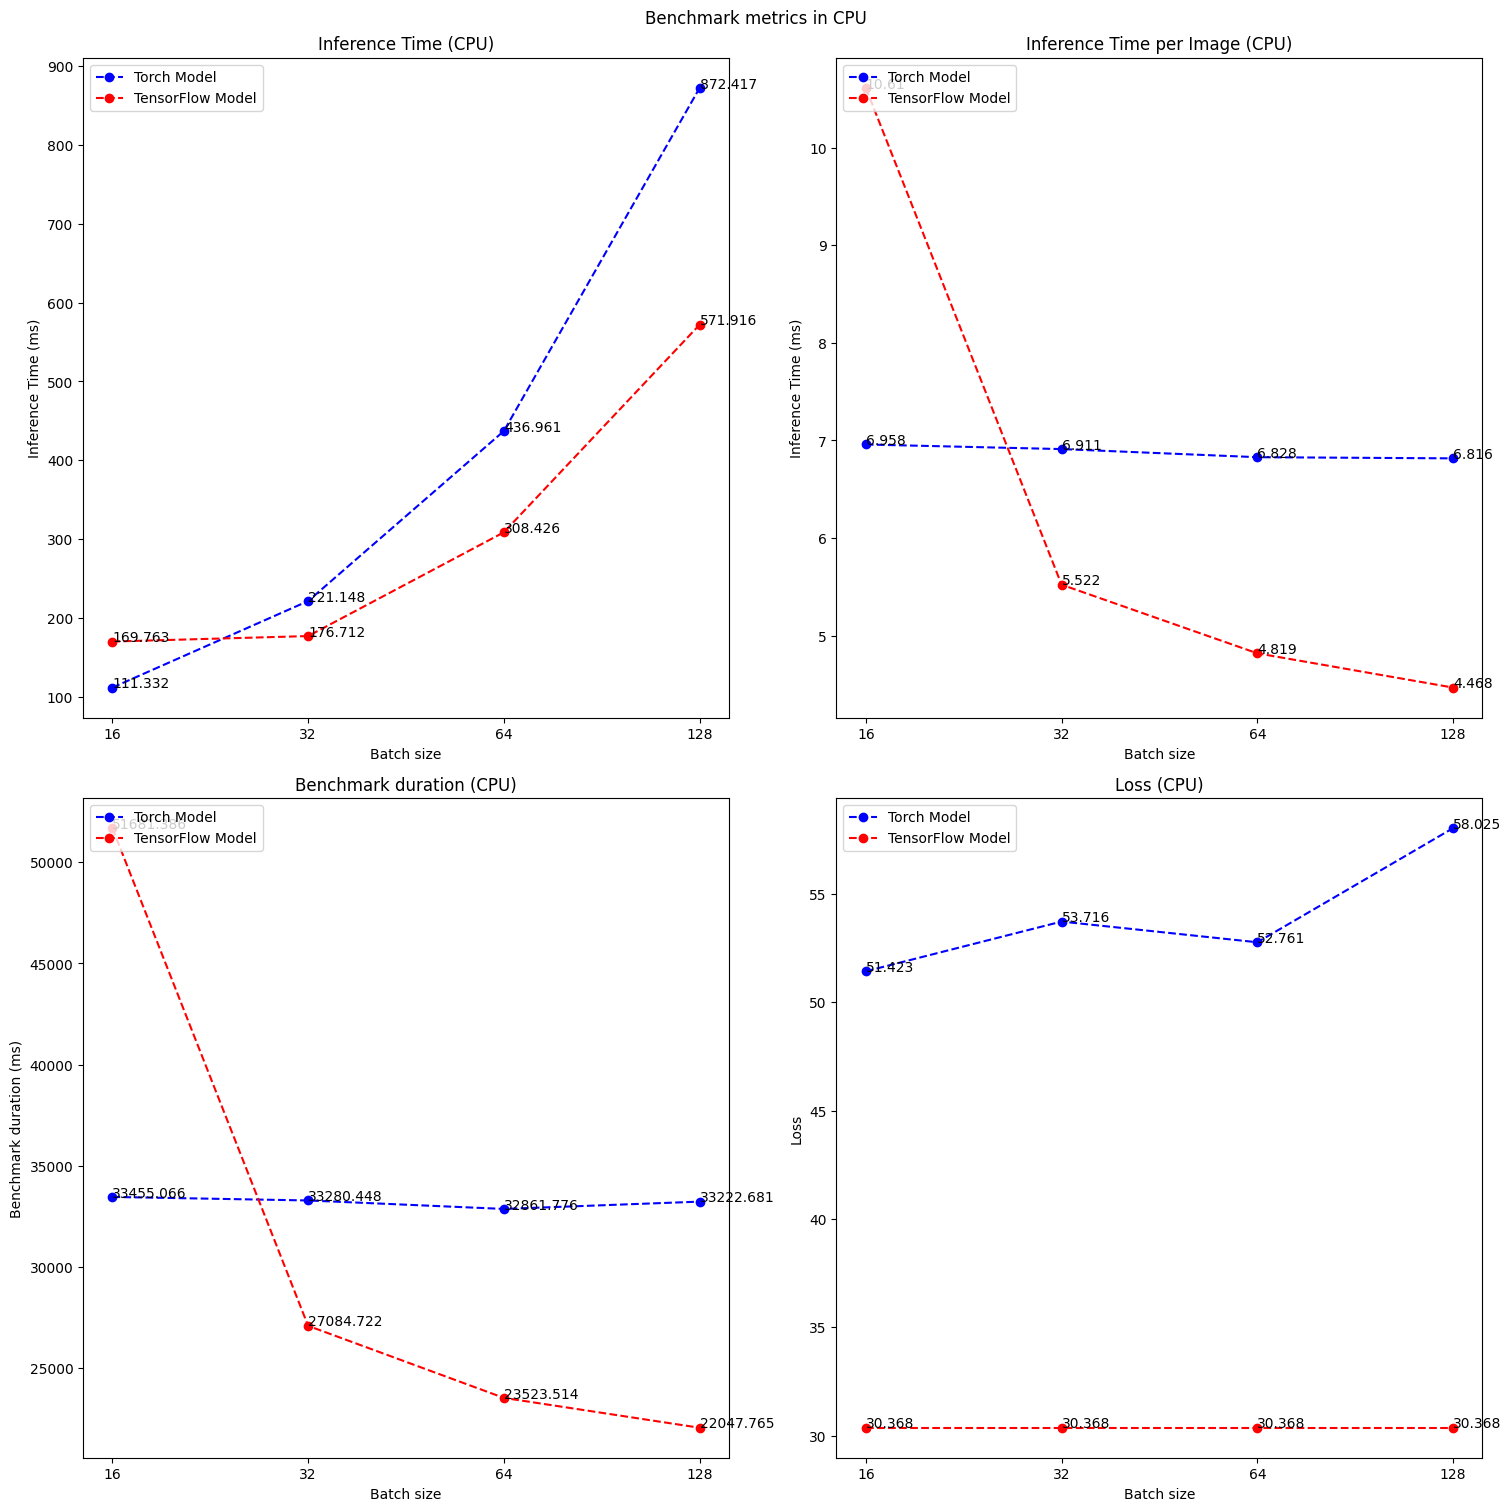

In [36]:
# CPU Performance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True)  # type: ignore
options = [
    { "env": "cpu", "metric": "perf_time_mean_per_batch_ms", "title": "Inference Time", "ylabel": "Inference Time (ms)" },
    { "env": "cpu", "metric": "perf_time_mean_per_image_ms", "title": "Inference Time per Image", "ylabel": "Inference Time (ms)" },
    { "env": "cpu", "metric": "test_time_ms", "title": "Benchmark duration", "ylabel": "Benchmark duration (ms)" },
    { "env": "cpu", "metric": "loss_mean", "title": "Loss", "ylabel": "Loss" }
]

for option, ax in zip(options, axs.flat):
    plot_benchmark_by_env_and_metric(ax, **option)

fig.suptitle('Benchmark metrics in CPU')  # type: ignore
plt.show()  # type: ignore

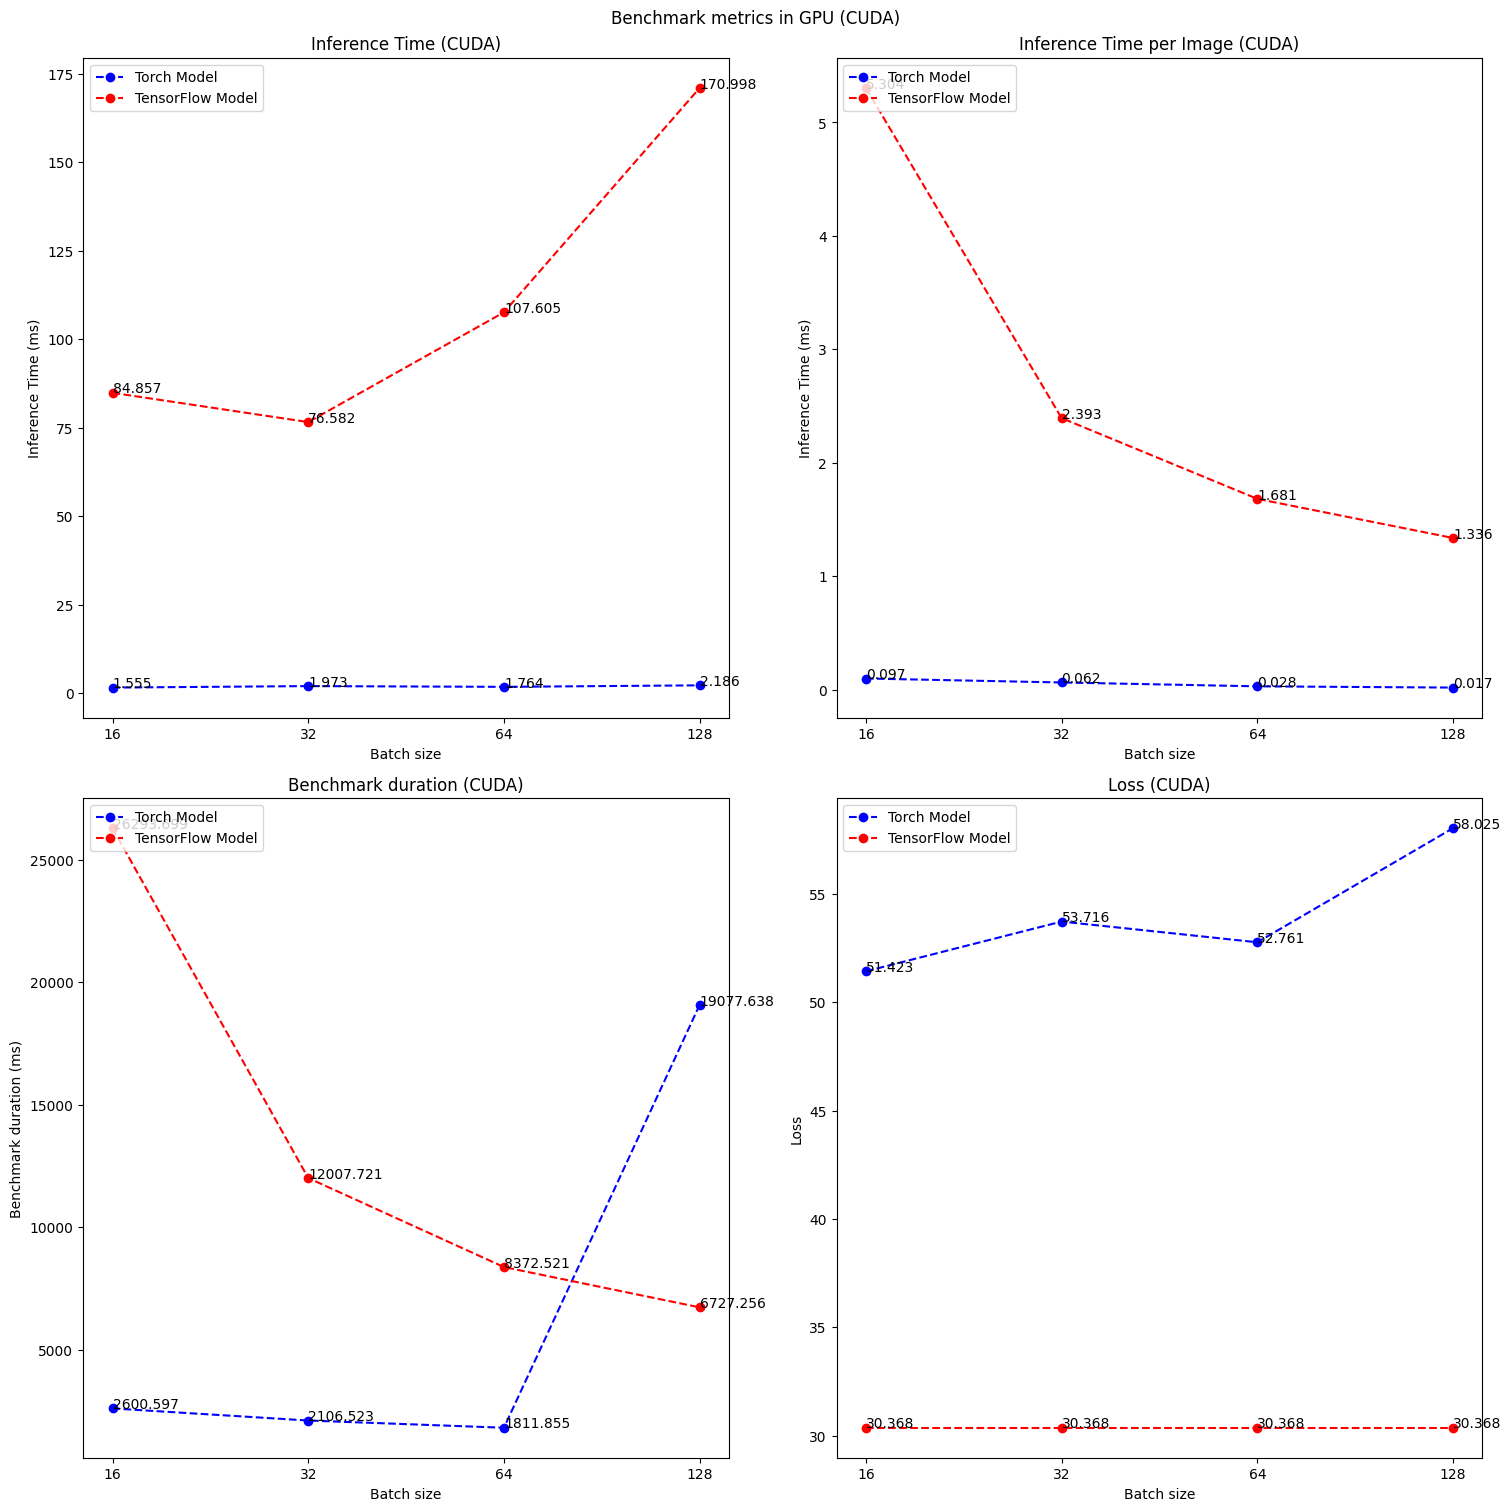

In [37]:
# GPU Performance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True)  # type: ignore
options = [
    { "env": "cuda", "metric": "perf_time_mean_per_batch_ms", "title": "Inference Time", "ylabel": "Inference Time (ms)" },
    { "env": "cuda", "metric": "perf_time_mean_per_image_ms", "title": "Inference Time per Image", "ylabel": "Inference Time (ms)" },
    { "env": "cuda", "metric": "test_time_ms", "title": "Benchmark duration", "ylabel": "Benchmark duration (ms)" },
    { "env": "cuda", "metric": "loss_mean", "title": "Loss", "ylabel": "Loss" }
]

for option, ax in zip(options, axs.flat):
    plot_benchmark_by_env_and_metric(ax, **option)

fig.suptitle('Benchmark metrics in GPU (CUDA)')  # type: ignore
plt.show()  # type: ignore